In [1]:
import os
import pandas as pd
import glob
import numpy as np

from scipy.stats import zscore

import gc

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

In [3]:
os.getcwd()

'/media/sf_eduseiti/unicamp/ia368v_dd/trabalho_final'

In [4]:
TRAIN_RESULTS_FOLDER="train_queries"
COLBERTX_TRAIN_RESULTS_FOLDER="train_queries/colbertx_retrieval"

COLBERT_RANKING_RESULTS_FILENAME_FORMAT="ranking_index_{:02}_parts_*.tsv"

In [5]:
CORPUS_PART_INICIAL_ID=[
    int(0),
    int(2e+6),
    int(4e+6),
    int(6e+6),
    int(8e+6)
]

In [6]:
GENERATED_TRAIN_QUERIES_FILENAME="generated_train_queries.tsv"

In [7]:
def combine_colbertx_retrievals(colbertx_retrievals_folder, corpus_parts=[0, 1, 2, 3, 4], combined_results_output_filename=None):
    
    znormalized_result_dfs = []
    
    for corpus_part in corpus_parts:
        
        print("Hanlding corpus part: {}...".format(corpus_part))
        
        corpus_part_retrieval_results = glob.glob(os.path.join(colbertx_retrievals_folder, COLBERT_RANKING_RESULTS_FILENAME_FORMAT.format(corpus_part)))
        
        print(corpus_part_retrieval_results)
        
        all_retrieval_results = []

        for retrieval_part in corpus_part_retrieval_results:
            all_retrieval_results.append(pd.read_csv(retrieval_part, sep='\t', header=None, names=['query_id', 'colbertx_id', 'doc_position', 'doc_score']))        
    
        all_retrieval_results_df = pd.concat(all_retrieval_results)
        
        all_retrieval_results_df['score_znorm'] = zscore(all_retrieval_results_df['doc_score'])
        all_retrieval_results_df['part'] = corpus_part
        all_retrieval_results_df['colbertx_id'] += CORPUS_PART_INICIAL_ID[corpus_part]
        
        znormalized_result_dfs.append(all_retrieval_results_df)
        
        
    combined_retrievals_df = pd.concat(znormalized_result_dfs).sort_values('score_znorm', ascending=False)
    
    if combined_results_output_filename is not None:
        combined_retrievals_df.to_csv(combined_results_output_filename, sep='\t', index=False)
        
    return combined_retrievals_df

### Combine all the train queries retrievals, performed over the different corpus parts 

In [8]:
train_scores_df = combine_colbertx_retrievals(COLBERTX_TRAIN_RESULTS_FOLDER)

Hanlding corpus part: 0...
['train_queries/colbertx_retrieval/ranking_index_00_parts_0_1_2.tsv', 'train_queries/colbertx_retrieval/ranking_index_00_parts_3_4_5.tsv', 'train_queries/colbertx_retrieval/ranking_index_00_parts_6_7_8.tsv', 'train_queries/colbertx_retrieval/ranking_index_00_parts_9.tsv']
Hanlding corpus part: 1...
['train_queries/colbertx_retrieval/ranking_index_01_parts_0_1_2.tsv', 'train_queries/colbertx_retrieval/ranking_index_01_parts_3_4_5.tsv', 'train_queries/colbertx_retrieval/ranking_index_01_parts_6_7_8.tsv', 'train_queries/colbertx_retrieval/ranking_index_01_parts_9.tsv']
Hanlding corpus part: 2...
['train_queries/colbertx_retrieval/ranking_index_02_parts_0_1_2.tsv', 'train_queries/colbertx_retrieval/ranking_index_02_parts_3_4_5.tsv', 'train_queries/colbertx_retrieval/ranking_index_02_parts_6_7_8.tsv', 'train_queries/colbertx_retrieval/ranking_index_02_parts_9.tsv']
Hanlding corpus part: 3...
['train_queries/colbertx_retrieval/ranking_index_03_parts_0_1_2.tsv', 'tr

In [9]:
train_scores_df.head(10)

,query_id,colbertx_id,doc_position,doc_score,score_znorm,part
1122201,1126,1567448,1,31.273457,5.427429,0
951113,954,4246529,1,31.191677,5.375750,2
1668051,1674,2388393,1,31.013552,5.284049,1
1667745,1674,9333981,1,31.013552,5.281916,4
1666937,1674,1150181,1,31.013552,5.279323,0
704732,1674,1904555,1,31.013552,5.279323,0
1014183,1018,6140371,1,31.004736,5.263548,3
1122202,1126,1370904,2,30.938503,5.236557,0
729975,732,2309538,1,30.929274,5.235999,1
1014353,1018,7399907,1,30.922974,5.217078,3


In [10]:
train_scores_df.to_csv(os.path.join(TRAIN_RESULTS_FOLDER, "all_znormalized_train_scores.tsv"), sep='\t', index=False)

### Evaluate train query reference document position in the Colbert-X retrieval

In [11]:
def search_document_result_for_query(all_results_df, query_id, doc_id):
    query_df = all_results_df[all_results_df['query_id'] == query_id].reset_index()
    
    return query_df[query_df['colbertx_id'] == doc_id]

In [12]:
def filter_queries(queries_df, all_results_df, doc_id_field='colbertx_id'):
    
    queries_retrieval_evaluation = []

    for i, query in queries_df.iterrows():

        print("---------------------")

        for j, which_question in enumerate(['question_theme', 'question_specific']):

            if query[which_question] is not None:
                query_search_results = search_document_result_for_query(all_results_df, (i * 2) + j, query[doc_id_field]).index
                
                if len(query_search_results) > 0:
                    position_found = query_search_results[0]
                else:
                    position_found = None

            print("query_id: {}, query: {}\n-- position: {}\n".format((i * 2) + j, query[which_question], position_found))

            if query[which_question] is not None:
                queries_retrieval_evaluation.append({"query_id": (i * 2) + j, 
                                                     "colbertx_id": query['colbertx_id'],
                                                     "clueweb_id": query['clueweb_id'], 
                                                     "position": position_found})
                
    return pd.DataFrame(queries_retrieval_evaluation)

In [13]:
train_queries_df = pd.read_csv(os.path.join(TRAIN_RESULTS_FOLDER, GENERATED_TRAIN_QUERIES_FILENAME), sep='\t')

In [14]:
colbertx_train_queries_evaluation_df = filter_queries(train_queries_df, train_scores_df)

---------------------
query_id: 0, query: O que é essa lista?
-- position: None

query_id: 1, query: Qual empresa está na posição 32 da lista?
-- position: 994

---------------------
query_id: 2, query: Qual foi a reação da pessoa ao abrir o aplicativo Pou?
-- position: 111

query_id: 3, query: O que aconteceu com a pessoa depois de jogar o Pou?
-- position: 88

---------------------
query_id: 4, query: O que são instrumentos de laboratório?
-- position: 3

query_id: 5, query: Por que é importante que os instrumentos de laboratório sejam de alta qualidade e duráveis?
-- position: 0

---------------------
query_id: 6, query: Qual é o objeto do contrato mencionado na passagem?
-- position: None

query_id: 7, query: Qual é o acréscimo em reais no valor total do contrato após a aplicação do reajuste contratual?
-- position: 3

---------------------
query_id: 8, query: Qual é o tema do fórum ou discussão?
-- position: None

query_id: 9, query: Quais são as regras de colocação para os usuári

query_id: 76, query: O que é LVM e como é utilizado em algumas distribuições Linux?
-- position: 14

query_id: 77, query: Como as pessoas podem se sentir em relação ao LVM no início, e como isso pode mudar com o tempo?
-- position: 259

---------------------
query_id: 78, query: Qual é a música de Natal mais popular de Mariah Carey?
-- position: 13

query_id: 79, query: Quem participa da nova versão do clipe de "All I Want For Christmas Is You" de Mariah Carey?
-- position: 0

---------------------
query_id: 80, query: Quais são as vantagens das atividades assíncronas em relação às síncronas?
-- position: 28

query_id: 81, query: Como a tecnologia evoluiu nos últimos 13 anos para permitir mais opções de plataformas de webconferência?
-- position: 174

---------------------
query_id: 82, query: Qual é a finalidade do termo de liberação mencionado na passagem?
-- position: 1

query_id: 83, query: Em que momento o termo aditivo pode ser lavrado e qual é a sua relação com a apresentação de

query_id: 142, query: Qual é o objetivo do material mencionado na passagem?
-- position: None

query_id: 143, query: Quais são os temas abordados nas aulas demonstrativas mencionadas na passagem?
-- position: 4331

---------------------
query_id: 144, query: Qual é o assunto abordado na questão?
-- position: None

query_id: 145, query: Qual é a classificação sintática do sujeito da forma verbal "notava"?
-- position: 0

---------------------
query_id: 146, query: O que significa sonhar com pé torto?
-- position: 0

query_id: 147, query: O que é sugerido pela passagem para entender melhor o momento amoroso e investir melhor a energia espiritual?
-- position: None

---------------------
query_id: 148, query: Qual é o erro que as pessoas estão enfrentando?
-- position: None

query_id: 149, query: Como é possível visualizar os débitos de Regularidade FGTS?
-- position: 15

---------------------
query_id: 150, query: Como negociar uma bolsa-auxílio de estágio?
-- position: 0

query_id: 151,

query_id: 208, query: Qual é o valor aproximado dos dividendos que a Enauta irá distribuir?
-- position: 0

query_id: 209, query: Por que o autor da passagem sugere que é necessário ter "um pouco de estômago" para comprar ações da Enauta?
-- position: 0

---------------------
query_id: 210, query: Qual é a função do Excel que permite montar um controle de estoque facilmente?
-- position: 0

query_id: 211, query: Como a validação de dados funciona no Excel para restringir o conteúdo da célula QUANT com base no valor da célula ESTOQUE?
-- position: 0

---------------------
query_id: 212, query: Qual é a visão do autor sobre a ação democrática?
-- position: None

query_id: 213, query: Quais são as relações de equivalência semântica presentes no texto?
-- position: 28

---------------------
query_id: 214, query: Qual é a especialidade do escritório de advocacia de Regina Beatriz Tavares da Silva?
-- position: 0

query_id: 215, query: Quem se tornou sócio de RBTSSA em 2010 e em que áreas el

query_id: 274, query: Qual foi a tendência criada por Sugar Minott no final dos anos 60?
-- position: 0

query_id: 275, query: Quais foram os cantores que emergiram como grandes astros no início da era do dancehall?
-- position: 0

---------------------
query_id: 276, query: Como um estagiário pode contribuir com a escola após a conclusão das atividades de estágio?
-- position: 3

query_id: 277, query: Qual é o título do trabalho proposto no plano de aula mencionado na passagem?
-- position: 658

---------------------
query_id: 278, query: Qual é a garantia constitucional relacionada à implementação do Plano Nacional de Cultura?
-- position: 0

query_id: 279, query: Quais são os componentes do Sistema Nacional de Cultura?
-- position: 3

---------------------
query_id: 280, query: Quais são as principais dificuldades enfrentadas pelos médicos em sua profissão?
-- position: 81

query_id: 281, query: Como a pressão da sociedade pode afetar a vida dos médicos?
-- position: 35

-----------

query_id: 346, query: Quais são as características da bicicleta infantil mencionada na passagem?
-- position: 111

query_id: 347, query: Quais são os prós e contras da bicicleta infantil mencionada na passagem?
-- position: 1

---------------------
query_id: 348, query: O que a comissão encontrou em diversas pedras isoladas em roda da mesma Gávea?
-- position: 0

query_id: 349, query: Qual a comparação feita pela comissão entre Pitágoras e Anaxágoras e a análise que eles fizeram da inscrição encontrada?
-- position: 0

---------------------
query_id: 350, query: O que é o projeto desenvolvido pelo software mencionado na passagem?
-- position: 1792

query_id: 351, query: Por que a dispensa de constituição de provisão para autuação da Secretaria da Receita Federal do Brasil foi mantida?
-- position: 0

---------------------
query_id: 352, query: Qual é a base legal para a responsabilidade objetiva do Estado?
-- position: 94

query_id: 353, query: Por que a responsabilidade objetiva do Es

query_id: 412, query: Como entrar em contato com a Caixa Econômica Federal para resolver problemas?
-- position: None

query_id: 413, query: Além dos canais de atendimento oficiais da Caixa, quais outras formas de contato podem ser utilizadas para resolver problemas com o banco?
-- position: None

---------------------
query_id: 414, query: Qual é a relação entre AVE criptogênico e forame oval patente?
-- position: None

query_id: 415, query: Qual é a prevalência de forame oval patente na população adulta?
-- position: None

---------------------
query_id: 416, query: O que significa a combinação de Lua e Cavaleiro nas cartas de tarô?
-- position: None

query_id: 417, query: Qual é o significado da combinação de Lua e Caixão nas cartas de tarô?
-- position: None

---------------------
query_id: 418, query: Quais são os critérios para idosos com renda igual ou inferior a 2 salários mínimos terem direito a benefícios de transporte?
-- position: 0

query_id: 419, query: Como funciona o pr

query_id: 478, query: Qual é o curso mencionado na passagem e qual é o seu objetivo?
-- position: None

query_id: 479, query: Como o curso de Atuação Consciente transformou a visão dos participantes sobre a infância e a educação?
-- position: 0

---------------------
query_id: 480, query: De acordo com a passagem, os lixões a céu aberto são uma boa alternativa para o tratamento do lixo? 
-- position: 2

query_id: 481, query: Quais itens são considerados como parte do saneamento básico, de acordo com a passagem?
-- position: 371

---------------------
query_id: 482, query: O que Jesus disse sobre a vinda da abominação desoladora?
-- position: None

query_id: 483, query: O que é descrito em Hebreus 13:15,16 sobre o "poder" do povo santo?
-- position: None

---------------------
query_id: 484, query: O que é pecado e qual é o castigo para ele?
-- position: 3

query_id: 485, query: Como Deus arranjou um meio de perdoar o pecado humano?
-- position: 1

---------------------
query_id: 486, q

query_id: 555, query: O que significa a luz vermelha no Carregador de Bolso do IQOS 2.4 Plus?
-- position: 0

---------------------
query_id: 556, query: Qual é o objetivo do Requiém de Marfim mencionado na passagem?
-- position: 1935

query_id: 557, query: O que o autor da passagem pensa sobre o uso de skills de solo antes de frenar?
-- position: 1

---------------------
query_id: 558, query: Qual é o curso oferecido pelo IDP Online?
-- position: 12

query_id: 559, query: Quais são as vantagens de escolher o IDP Online para fazer um curso de MBA em Direito e Regulação do Setor Elétrico?
-- position: 0

---------------------
query_id: 560, query: Qual é o objetivo da pesquisa de CEP mencionada na passagem?
-- position: None

query_id: 561, query: Qual é o endereço completo da Rua Chico Pontes em São Paulo?
-- position: None

---------------------
query_id: 562, query: Quais são alguns recursos e softwares complementares que podem ser usados para melhorar um perfil no Instagram?
-- posi

query_id: 621, query: É possível converter um carro convencional em um carro movido a água com o uso de um kit de hidrogênio?
-- position: None

---------------------
query_id: 622, query: Quais são os temas dos templates de PowerPoint e Google Slides gratuitos?
-- position: None

query_id: 623, query: Como o modelo de apresentação de desenho botânico pode ser utilizado em diferentes áreas além de alimentos orgânicos e cosméticos?
-- position: None

---------------------
query_id: 624, query: Qual é o objetivo do artigo?
-- position: None

query_id: 625, query: Qual é o setor da empresa que o artigo se concentra em melhorar?
-- position: None

---------------------
query_id: 626, query: Quais são as aplicações do gás hélio na indústria?
-- position: 4

query_id: 627, query: Como o gás hélio é utilizado na área da saúde?
-- position: 0

---------------------
query_id: 628, query: Por que a instalação do Fusion Inventory via GPO não funcionou no parque de informática do autor?
-- positio

query_id: 687, query: Como as mudanças nas formas de contratação e pagamento da força de trabalho afetaram o processo de seleção social dos trabalhadores na citricultura?
-- position: 0

---------------------
query_id: 688, query: Qual era a posição inicial do Conselho Nacional de Justiça em relação ao acesso aos autos de processo?
-- position: 0

query_id: 689, query: O que mudou com a edição da Resolução n. 121/2010 em relação ao acesso aos dados dos processos judiciais?
-- position: 1

---------------------
query_id: 690, query: Quais são os exames oferecidos pela clínica Med Imagem?
-- position: 0

query_id: 691, query: Quais cidades são atendidas pela clínica Med Imagem?
-- position: 0

---------------------
query_id: 692, query: Como a cultura influencia a construção do corpo?
-- position: 3

query_id: 693, query: Por que a mulher brasileira é campeã na busca pela perfeição corporal?
-- position: 0

---------------------
query_id: 694, query: O que é o índice Dow Jones U.S. Selec

query_id: 762, query: É fácil ganhar dinheiro na internet?
-- position: 0

query_id: 763, query: É possível iniciar um negócio na internet com pouco dinheiro?
-- position: 12

---------------------
query_id: 764, query: Qual é o prazo para que o sócio ou pessoa jurídica se manifeste após a instauração do incidente de desconsideração da personalidade jurídica?
-- position: None

query_id: 765, query: Por que a aplicação do § 2º, do art. 231, do Código de Processo Civil é inadequada para a hipótese de citação no incidente de desconsideração da personalidade jurídica?
-- position: None

---------------------
query_id: 766, query: Como funciona o processo de refrigeração na conservação de alimentos?
-- position: None

query_id: 767, query: Quais frutas e verduras não devem ser armazenadas na geladeira e por quê?
-- position: None

---------------------
query_id: 768, query: Quais são os métodos de avaliação mais comuns utilizados pelos professores?
-- position: 198

query_id: 769, query: Q

query_id: 832, query: Quais são algumas combinações comuns de carnes para fazer hambúrguer?
-- position: 8

query_id: 833, query: É possível errar na hora de criar o blend de carne para hambúrguer?
-- position: 1

---------------------
query_id: 834, query: Quais universidades lideram historicamente os rankings no Brasil?
-- position: 7

query_id: 835, query: Qual é o novo ranking de universidades da Folha de São Paulo e como ele foi obtido?
-- position: 0

---------------------
query_id: 836, query: Qual é a diferença de potencial durante a quiescência elétrica nas células cardíacas?
-- position: 0

query_id: 837, query: Qual é o íon que determina predominantemente o nível do potencial de repouso transmembrana nas células cardíacas?
-- position: 0

---------------------
query_id: 838, query: O que é a modalidade de guarda compartilhada chamada de aninhamento?
-- position: 0

query_id: 839, query: Qual é o objetivo da guarda compartilhada na mediação familiar?
-- position: 2

---------


query_id: 905, query: Como é possível economizar na viagem para Cancun e Riviera Maia?
-- position: 3

---------------------
query_id: 906, query: Por que o nosso organismo precisa de gordura?
-- position: 6

query_id: 907, query: Quais são os alimentos ricos em gordura saturada e por que eles podem ser prejudiciais à saúde?
-- position: 1

---------------------
query_id: 908, query: Qual é o resultado da operação matemática 4³ + 3 elevado a 4?
-- position: 4241

query_id: 909, query: Qual é a forma correta de somar as variáveis x e y?
-- position: None

---------------------
query_id: 910, query: Qual é o melhor indicador para saber se um pão engorda ou emagrece?
-- position: 0

query_id: 911, query: Por que o pão é um dos primeiros alimentos a ser retirado da alimentação em uma dieta restritiva?
-- position: 1

---------------------
query_id: 912, query: Quais são as fontes citadas na passagem?
-- position: None

query_id: 913, query: Qual é a situação das rodovias estaduais no Cear

query_id: 977, query: O B2W Marketplace solicita algum tipo de investimento inicial para começar a vender?
-- position: 0

---------------------
query_id: 978, query: Qual é o objetivo da multa mencionada no artigo 537?
-- position: 71

query_id: 979, query: O que mudou com a nova redação do artigo 50 da Lei 9.099/1995, de acordo com o artigo 1.065 do novo CPC?
-- position: 4

---------------------
query_id: 980, query: O que são as "pedaladas fiscais"?
-- position: 8

query_id: 981, query: Quais foram as consequências do processo de impeachment de Dilma Rousseff?
-- position: 798

---------------------
query_id: 982, query: Qual é o tema da atividade online?
-- position: None

query_id: 983, query: Qual é a resposta correta para a questão sobre movimentos da ginástica?
-- position: 3

---------------------
query_id: 984, query: Qual é o assunto principal do parecer?
-- position: None

query_id: 985, query: Por que a prorrogação excepcional por até um ano é justificável?
-- position: 5

query_id: 1050, query: Quais são os sintomas da doença relacionada ao espessamento do endométrio?
-- position: 4

query_id: 1051, query: Qual é a relação entre a lactação prolongada e a redução da probabilidade de oncologia endometrial?
-- position: 0

---------------------
query_id: 1052, query: Qual é o motivo da saída das mercadorias e bens do ativo imobilizado do estabelecimento?
-- position: 441

query_id: 1053, query: O saldo credor de ICMS será automaticamente transferido para a nova Inscrição Estadual ou a Consulente precisa realizar algum procedimento para a manutenção do saldo credor na nova Inscrição Estadual?
-- position: 0

---------------------
query_id: 1054, query: Como a taxa Selic afeta os juros de empréstimos e outras modalidades de crédito?
-- position: 0

query_id: 1055, query: Como a taxa Selic afeta os investimentos em Renda Fixa?
-- position: 2

---------------------
query_id: 1056, query: Qual é o tema principal abordado na passagem?
-- position: None

query_id

query_id: 1121, query: Quais são os motivos que levaram as pessoas a comprar o produto Linus?
-- position: 7

---------------------
query_id: 1122, query: Quais são as restrições para visitar os pontos turísticos devido à COVID-19?
-- position: 10

query_id: 1123, query: Qual é a melhor época para visitar o PETAR e por que?
-- position: 2

---------------------
query_id: 1124, query: Quais são as séries que terão novas temporadas em 2022 na Netflix?
-- position: 0

query_id: 1125, query: Por que muitas séries famosas da Netflix tiveram que ficar em hiatos maiores?
-- position: 0

---------------------
query_id: 1126, query: Qual é o objetivo do Programa de Alimentação do Trabalhador (PAT)?
-- position: 70

query_id: 1127, query: Por que é importante que as empresas que fornecem refeições coletivas tenham a orientação de um nutricionista?
-- position: 0

---------------------
query_id: 1128, query: Qual foi o jogo lançado pela On-Line em 1992 que ficou conhecido por sua ruindade?
-- pos

query_id: 1186, query: Qual é a descrição física do arbusto mencionado na passagem?
-- position: 1754

query_id: 1187, query: Em quais estados brasileiros a espécie foi citada e qual é a sua representatividade nas coleções dos herbários estudados?
-- position: 0

---------------------
query_id: 1188, query: Quais são as funções e processos disponíveis no Metropasse Online?
-- position: 0

query_id: 1189, query: Quais são os procedimentos para solicitar bloqueio de cartões perdidos ou roubados?
-- position: 68

---------------------
query_id: 1190, query: Qual é o objetivo das brincadeiras na escola mencionada na passagem?
-- position: None

query_id: 1191, query: Quais são os elementos importantes a serem trabalhados na escola mencionada na passagem?
-- position: 4872

---------------------
query_id: 1192, query: Qual é o objetivo da dinâmica de modelar massinhas?
-- position: 0

query_id: 1193, query: Qual é o objetivo da dinâmica dos Talentos e o que é necessário para realizá-la?
-- 


---------------------
query_id: 1262, query: O que é infantilidade em psicologia?
-- position: 0

query_id: 1263, query: Quais são os fatores que contribuem para o desenvolvimento da infantilidade em uma pessoa?
-- position: 0

---------------------
query_id: 1264, query: Qual é o salário médio de um balconista no Rio de Janeiro em 2022?
-- position: 0

query_id: 1265, query: Qual é o valor médio do vale refeição e o reajuste para balconistas no Rio Grande do Norte em 2022?
-- position: 0

---------------------
query_id: 1266, query: Quais são os endereços e horários de funcionamento da Royal Enfield em São Paulo?
-- position: 1

query_id: 1267, query: Qual é o contato para peças e consultoria na Royal Enfield em São Paulo?
-- position: 0

---------------------
query_id: 1268, query: Quem liderou a revolta dos samaritanos em 529?
-- position: 0

query_id: 1269, query: Qual foi o impacto da repressão do Império Bizantino sobre a população samaritana?
-- position: 0

-------------------

query_id: 1333, query: Quantos lotes foram negociados pelo grupo Zamm no último ano?
-- position: 0

---------------------
query_id: 1334, query: Qual é a melhor opção de aeroporto para embarcar em São Paulo com destino a Milão?
-- position: 0

query_id: 1335, query: Quais são as companhias aéreas que operam voos diretos de São Paulo para Milão?
-- position: 0

---------------------
query_id: 1336, query: Qual é a realidade vivenciada pelos alunos?
-- position: 3

query_id: 1337, query: Qual é a solução proposta pelo aluno para lidar com o sentimento de isolamento?
-- position: 0

---------------------
query_id: 1338, query: Qual é o prazo máximo para ajuizar uma ação rescisória?
-- position: 12

query_id: 1339, query: Por que a relativização da coisa julgada inconstitucional é problemática?
-- position: 0

---------------------
query_id: 1340, query: Como baixar papéis de parede animados para o computador?
-- position: 130

query_id: 1341, query: Quais são as categorias de papéis de p

query_id: 1409, query: O que é um Sextil e quais signos fazem esse aspeto?
-- position: 7

---------------------
query_id: 1410, query: Qual foi a causa da queda da indústria de açúcar em São Tomé?
-- position: 0

query_id: 1411, query: Quem liderou a revolta de escravos em São Tomé em 1595?
-- position: 9

---------------------
query_id: 1412, query: Quais são os principais serviços oferecidos pela Urbam?
-- position: 3

query_id: 1413, query: Como é possível acompanhar a programação do Estádio Martins Pereira?
-- position: 3

---------------------
query_id: 1414, query: Qual é o tema da tese de doutorado de Gilson Lucio Rodrigues?
-- position: 0

query_id: 1415, query: O que são as "Dicas de prevenção de acidentes e doenças no trabalho" do SESI-SEBRAE?
-- position: 1

---------------------
query_id: 1416, query: Quais são os indicadores de saúde discutidos na passagem?
-- position: 3114

query_id: 1417, query: Como os Sistemas de Informações em Saúde podem ser úteis para a Estratégia

query_id: 1481, query: Como a ausência de informações completas pode atrapalhar os candidatos na apresentação da documentação correta em um processo seletivo?
-- position: 0

---------------------
query_id: 1482, query: Para quais tipos de cabelo a máscara Morte Súbita é indicada?
-- position: 0

query_id: 1483, query: A máscara Morte Súbita pode auxiliar na reconstrução capilar?
-- position: 0

---------------------
query_id: 1484, query: Qual é o objetivo do diálogo das palavras e da ação na imitação do mestre?
-- position: 0

query_id: 1485, query: Como os practicums reflexivos podem ocorrer em diferentes estágios da formação profissional?
-- position: 0

---------------------
query_id: 1486, query: Quais são os fatores que influenciam na escolha de um carro?
-- position: None

query_id: 1487, query: Quantas marchas possui o câmbio manual do Toyota Corolla LE 1996?
-- position: 0

---------------------
query_id: 1488, query: Qual é a função do software de tradução online gratuito me

query_id: 1553, query: Para que serve o cookie "viewed_cookie_policy"?
-- position: None

---------------------
query_id: 1554, query: O que é essa sequência de números e pontos?
-- position: None

query_id: 1555, query: Qual é o padrão ou a lógica por trás dessa sequência de números e pontos?
-- position: None

---------------------
query_id: 1556, query: O que significa a expressão "tiririca"?
-- position: 9

query_id: 1557, query: Qual é a diferença entre "tu" e "você" na linguagem cearense?
-- position: 29

---------------------
query_id: 1558, query: Quais são os riscos de acidentes de trabalho no home office?
-- position: 0

query_id: 1559, query: Quem é responsável pelos casos de doenças ou acidentes de trabalho no modelo home office?
-- position: 9

---------------------
query_id: 1560, query: Quais são as características das telhas recomendadas para aplicações em coberturas?
-- position: 3

query_id: 1561, query: Qual é a telha com maior rendimento por metro quadrado e para qu

query_id: 1627, query: Qual foi o enredo da escola de samba em 2015 e qual foi a sua colocação?
-- position: 31

---------------------
query_id: 1628, query: Quais são os alimentos que devem ser evitados para evitar o ganho de gordura corporal?
-- position: 0

query_id: 1629, query: Por que as bebidas alcoólicas podem atrapalhar o ganho de massa muscular?
-- position: 14

---------------------
query_id: 1630, query: Qual é a função do ibuprofeno?
-- position: 200

query_id: 1631, query: Quais são as contraindicações para o uso do Buprovil Comprimido?
-- position: 0

---------------------
query_id: 1632, query: Qual é o valor do imóvel rural à venda?
-- position: 1172

query_id: 1633, query: Quais são as características do imóvel rural à venda?
-- position: None

---------------------
query_id: 1634, query: Quais são as opções de customização de carros em GTA V?
-- position: 0

query_id: 1635, query: Qual é o risco que os jogadores correm ao guardar seus carros em garagens em GTA V?
-- 

query_id: 1693, query: Quantos recursos e coleções estão disponíveis nas imagens de banner de Ano Novo de 2022?
-- position: 0

---------------------
query_id: 1694, query: Quais são as receitas que podem ser feitas com peixe?
-- position: 12276

query_id: 1695, query: Quais são as dicas para limpar peixe de maneira prática?
-- position: 0

---------------------
query_id: 1696, query: Quais são as principais personalidades literárias criadas por Fernando Pessoa?
-- position: 0

query_id: 1697, query: Qual é a principal característica da poesia de Fernando Pessoa em relação à poesia romântica?
-- position: 0

---------------------
query_id: 1698, query: Qual é a área de expertise da advogada mencionada na passagem?
-- position: None

query_id: 1699, query: Quais são as comissões das quais a advogada é presidente?
-- position: None

---------------------
query_id: 1700, query: Qual é o período de Recesso Forense no TJGO em 2021/2022?
-- position: 0

query_id: 1701, query: Como ficam os p

query_id: 1765, query: Como testar se um módulo de memória RAM está avariado em um notebook?
-- position: 0

---------------------
query_id: 1766, query: Quando é necessário induzir o vômito?
-- position: 0

query_id: 1767, query: Quais são os cinco passos para induzir o vômito corretamente?
-- position: 0

---------------------
query_id: 1768, query: O que são coordenadas geográficas e qual sua importância para as representações cartográficas?
-- position: 6

query_id: 1769, query: Quais estados brasileiros estão localizados na zona temperada do sul?
-- position: 2

---------------------
query_id: 1770, query: Qual é o objetivo da modernização do corredor de trólebus no ABC Paulista?
-- position: 0

query_id: 1771, query: Como o novo centro de controle de energia poderá ajudar a restabelecer a operação em caso de queda de energia?
-- position: 5

---------------------
query_id: 1772, query: Qual é a finalidade dos artigos e aparelhos para fraturas?
-- position: 1

query_id: 1773, quer

query_id: 1838, query: Qual é o tema principal da passagem?
-- position: None

query_id: 1839, query: Qual é a jurisprudência fixada pelo Assento DD65 do Supremo Tribunal de Justiça?
-- position: 2

---------------------
query_id: 1840, query: Quais são as possíveis reações alérgicas que podem ocorrer com o uso de alguns medicamentos?
-- position: 2638

query_id: 1841, query: O que deve ser feito em caso de reações alérgicas graves?
-- position: 800

---------------------
query_id: 1842, query: Qual é o objetivo da IN mencionada na passagem?
-- position: 3749

query_id: 1843, query: De acordo com o autor, a publicação da IN torna o processo de comércio exterior menos burocrático?
-- position: 0

---------------------
query_id: 1844, query: Quais são as coberturas do seguro para equipamentos eletrônicos?
-- position: 29

query_id: 1845, query: O que é considerado como exclusão do seguro para equipamentos eletrônicos?
-- position: 0

---------------------
query_id: 1846, query: Qual é o 

query_id: 1912, query: O que é essa sequência de números e pontos?
-- position: None

query_id: 1913, query: Qual é o propósito dessa sequência de números e pontos?
-- position: None

---------------------
query_id: 1914, query: O que é a ressaca e por que ela ocorre?
-- position: 0

query_id: 1915, query: É verdade que beber apenas um tipo de bebida alcoólica não causa ressaca?
-- position: 0

---------------------
query_id: 1916, query: O que é a CID e qual é a sua importância?
-- position: 9

query_id: 1917, query: Qual é a principal mudança na nova versão da CID em relação à versão anterior?
-- position: 9

---------------------
query_id: 1918, query: Quais são as propriedades medicinais da sálvia?
-- position: 0

query_id: 1919, query: Como a sálvia pode ajudar a tratar problemas do ciclo menstrual e sintomas da menopausa?
-- position: 0

---------------------
query_id: 1920, query: Quais são as soluções oferecidas pela Stelo?
-- position: 3

query_id: 1921, query: Como a Stelo se

query_id: 1987, query: Qual é o utilitário gratuito que o autor pode usar para realizar as configurações desejadas no Windows?
-- position: 7323

---------------------
query_id: 1988, query: Qual é a mensagem principal do texto?
-- position: None

query_id: 1989, query: O que o autor diz sobre a misericórdia de Deus?
-- position: None

---------------------
query_id: 1990, query: Qual é a importância da Educação Infantil?
-- position: 233

query_id: 1991, query: Quais ações a Secretaria de Educação tem tomado para apoiar os alunos da Rede Municipal durante a pandemia?
-- position: 3434

---------------------
query_id: 1992, query: O que é um arquivo PDF e para que é usado?
-- position: None

query_id: 1993, query: Onde é recomendado comprar o livro "Entendendo Algoritmos: Um Guia Ilustrado Para Programadores e Outros Curiosos" e por quê?
-- position: None

---------------------
query_id: 1994, query: O que é o ReclameAqui?
-- position: 91

query_id: 1995, query: Como funciona o acesso 

In [15]:
train_scores_df[train_scores_df['query_id'] == 1990]

,query_id,colbertx_id,doc_position,doc_score,score_znorm,part
1981349,1990,2227756,1,29.974356,4.691570,1
1981885,1990,8020403,1,29.901009,4.647514,4
1981486,1990,9488408,1,29.901009,4.647514,4
1980925,1990,118974,1,29.902670,4.646291,0
1981348,1990,5816655,1,29.682871,4.516994,2
...,...,...,...,...,...,...
1982878,1990,8620167,994,15.072550,-3.808065,4
1980949,1990,7117287,929,15.021910,-3.820420,3
1982940,1990,4520182,975,14.958858,-3.863371,2
1982307,1990,5554463,960,14.879776,-3.908382,2


In [16]:
colbertx_train_queries_evaluation_df.to_csv(os.path.join(TRAIN_RESULTS_FOLDER, "train_queries_colbertx_filter.tsv"), sep="\t", index=False)

### Simple analysis over the filtered data

In [17]:
colbertx_train_queries_evaluation_df['position'].describe()

count     1645.000000
mean       325.650456
std       1519.426579
min          0.000000
25%          0.000000
50%          1.000000
75%         14.000000
max      15892.000000
Name: position, dtype: float64

In [18]:
colbertx_train_queries_evaluation_df[colbertx_train_queries_evaluation_df['position'] < 5].shape

(1080, 4)

<AxesSubplot:>

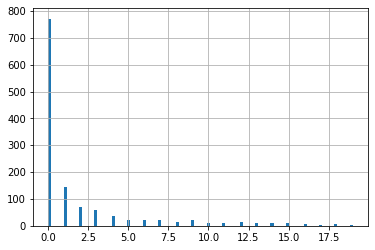

In [19]:
colbertx_train_queries_evaluation_df[colbertx_train_queries_evaluation_df['position'] < 20]['position'].hist(bins=100)